In [2]:
# import modules
import uproot, sys, time, math, pickle, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from scipy.special import betainc
from scipy.stats import norm

# import config functions
sys.path.append('/home/jlai/dark_photon/code/config')
from plot_config import getWeight, zbi, sample_dict, getVarDict
from plot_var import variables, variables_mc, ntuple_names
from n_1_iteration_functions import get_best_cut, calculate_significance, apply_cut_to_fb, apply_all_cuts, compute_total_significance, n_minus_1_optimizer
# from cut_config import cut_config

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high  
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 14,
    "title": 20
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"],  # Legend
    "axes.titlesize": font_size["title"] # Title
})


tot = []
data = pd.DataFrame()

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

def print_cut(ntuple_name, fb, label):
    print(f"{ntuple_name} Unweighted Events {label}: ", len(fb))
    print(f"{ntuple_name} Weighted Events {label}: ", sum(getWeight(fb, ntuple_name)))
        
for i in range(len(ntuple_names)):
    start_time = time.time()
    ntuple_name = ntuple_names[i]
    path = f"/data/fpiazza/ggHyyd/NtuplesWithBDTSkim/{ntuple_name}_nominal_bdt.root"
    f = uproot.open(path)['nominal']
    if ntuple_name.startswith("mc"):
        fb = f.arrays(variables+variables_mc, library='ak')
        print_cut(ntuple_name, fb, 'before cut')
        
        fb = fb[ak.num(fb['ph_eta']) > 0]     # for abs(ak.firsts(fb['ph_eta'])) to have value to the reweighting
        fb = fb[fb['n_ph'] == 1]
        fb = fb[fb['n_el_baseline'] == 0]

        # goodPV on signal only
        if ntuple_name == 'ggHyyd':
            fb = fb[ak.num(fb['pv_z']) > 0]
            good_pv_tmp = (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5)
            fb = fb[good_pv_tmp]
            
        
    if (ntuple_name == "data23_y") or (ntuple_name == "data24_y"):  # jet-faking 
        fb = f.arrays(variables, library='ak')
        print_cut(ntuple_name, fb, 'before cut')

        fb = fb[ak.num(fb['ph_eta']) > 0]
        mask1 = (ak.firsts(fb['ph_topoetcone40'])-2450.)/ak.firsts(fb['ph_pt']) > 0.1   # jet_faking_photon cut
        fb = fb[mask1]
        fb = fb[fb['n_ph_baseline'] == 1]
        fb = fb[fb['n_el_baseline'] == 0]


    if (ntuple_name == "data23_eprobe") or (ntuple_name == "data24_eprobe"): # electron-faking
        fb = f.arrays(variables, library='ak')
        print_cut(ntuple_name, fb, 'before cut')
        
        fb = fb[fb['n_el'] == 1]
        fb = fb[fb['n_ph_baseline'] == 0]

        # using electron info for photon info
        fb['ph_pt'] = fb['el_pt']
        fb['ph_eta'] = fb['el_eta']
        fb['ph_phi'] = fb['el_phi']
        fb['dphi_met_phterm'] = fb['dphi_met_eleterm']  

    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[ak.firsts(fb['ph_pt']) >= 50000] # ph_pt cut (basic cut)
    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[fb['met_tst_et'] >= 100000] # MET cut (basic cut)
    fb = fb[fb['n_jet_central'] <= 3] # n_jet_central cut (basic cut)
    
    fb['VertexBDTScore'] = fb['BDTScore'] # renaming BDTScore to ensure this is recognized as Vertex BDT Score
    fb = fb[fb['VertexBDTScore'] > 0.1]
    
    mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                    (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    mask1 = mt_tmp > 100
    mask2 = mt_tmp < 140
    fb = fb[mask1 * mask2]

    fb['weights'] = getWeight(fb, ntuple_name)
    
    print_cut(ntuple_name, fb, 'after basic')

    test(fb) # check for none value

    print(f"Reading Time for {ntuple_name}: {(time.time()-start_time)} seconds\n")

    tot.append(fb)

    del fb 

# combining 23d + 23e {Zgamma (1, 6), Wgamma (2, 7), gammajet_direct (3, 8)}
# combining 2023 + 2024 {data_y (4, 9), data_eprobe (5, 10)}
tot_tmp = tot
tot = [tot_tmp[0]]
for i in tqdm(range(5)):
    tot.append(ak.concatenate([tot_tmp[i+1], tot_tmp[i+6]]))
ntuple_names = ["ggHyyd", "Zgamma", "Wgamma", "gammajet_direct", "data_y", "data_eprobe"]
del tot_tmp


mc23d_ggHyyd_y Unweighted Events before cut:  17999
mc23d_ggHyyd_y Weighted Events before cut:  476.41051071983003
mc23d_ggHyyd_y Unweighted Events after basic:  2627
mc23d_ggHyyd_y Weighted Events after basic:  71.04948243695699
Number of none values:  0
Reading Time for mc23d_ggHyyd_y: 0.39095211029052734 seconds

mc23d_Zgamma_y Unweighted Events before cut:  2520609
mc23d_Zgamma_y Weighted Events before cut:  21734.468674981053
mc23d_Zgamma_y Unweighted Events after basic:  19478
mc23d_Zgamma_y Weighted Events after basic:  265.2141821877743
Number of none values:  0
Reading Time for mc23d_Zgamma_y: 16.48499608039856 seconds

mc23d_Wgamma_y Unweighted Events before cut:  685525
mc23d_Wgamma_y Weighted Events before cut:  23464.591275458304
mc23d_Wgamma_y Unweighted Events after basic:  13933
mc23d_Wgamma_y Weighted Events after basic:  535.5532902564596
Number of none values:  0
Reading Time for mc23d_Wgamma_y: 4.542269468307495 seconds

mc23d_gammajet_direct_y Unweighted Events bef

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


In [ ]:
signal_name = 'ggHyyd'
tot2 = []
for i in range(len(tot)):
    fb = tot[i]
    # ---------- INTERNAL SELECTION CUT ------------
    fb = fb[fb['VertexBDTScore'] > 0.1]
    
    metsig_tmp = fb['met_tst_sig'] 
    mask1 = metsig_tmp > 7
    fb = fb[mask1]
    
    ph_eta_tmp = np.abs(ak.firsts(fb['ph_eta']))
    fb = fb[ph_eta_tmp < 1.75]

    dphi_met_phterm_tmp = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) # added cut 3
    fb = fb[dphi_met_phterm_tmp > 1.35]

    dmet_tmp = fb['met_tst_noJVT_et'] - fb['met_tst_et']
    mask1 = dmet_tmp > -20000
    fb = fb[mask1]

    dphi_jj_tmp = fb['dphi_central_jj']
    dphi_jj_tmp = ak.where(dphi_jj_tmp == -10, np.nan, dphi_jj_tmp)
    dphi_jj_tmp = np.arccos(np.cos(dphi_jj_tmp))
    dphi_jj_tmp = ak.where(np.isnan(dphi_jj_tmp), -999, dphi_jj_tmp)
    fb = fb[dphi_jj_tmp < 2.5]

    dphi_met_jetterm_tmp = np.where(fb['met_jetterm_et'] != 0,   # added cut 5
                        np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                        -999)
    fb = fb[dphi_met_jetterm_tmp < 0.75]
    
    '''
    # ---------- SELECTION CUT ------------

    metsig_tmp = fb['met_tst_sig'] 
    mask1 = metsig_tmp > 7
    # fb = fb[mask1]
    mask2 = metsig_tmp < 16
    fb = fb[mask1 * mask2]
    
    ph_eta_tmp = np.abs(ak.firsts(fb['ph_eta']))
    fb = fb[ph_eta_tmp < 1.74]

    dphi_met_phterm_tmp = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) # added cut 3
    fb = fb[dphi_met_phterm_tmp > 1.35]

    dmet_tmp = fb['met_tst_noJVT_et'] - fb['met_tst_et']
    mask1 = dmet_tmp > -17900
    # fb = fb[mask1]
    mask2 = dmet_tmp < 41900
    fb = fb[mask1 * mask2]

    dphi_jj_tmp = fb['dphi_central_jj']
    dphi_jj_tmp = ak.where(dphi_jj_tmp == -10, np.nan, dphi_jj_tmp)
    dphi_jj_tmp = np.arccos(np.cos(dphi_jj_tmp))
    dphi_jj_tmp = ak.where(np.isnan(dphi_jj_tmp), -999, dphi_jj_tmp)
    fb = fb[dphi_jj_tmp < 2.58]

    dphi_met_jetterm_tmp = np.where(fb['met_jetterm_et'] != 0,   # added cut 5
                        np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                        -999)
    fb = fb[dphi_met_jetterm_tmp < 0.73]
'''
    # # ---------- FURTHER SELECTION CUT ------------
    jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
    expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
    balance_tmp = ak.where(jet_sum_tmp != 0, expr, -999)
    mask_nan = balance_tmp == -999
    mask = mask_nan | (balance_tmp > 0.90)
    fb = fb[mask]


    # ------------ mT cut ---------------
    # mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
    #                     (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    # mask1 = mt_tmp > 80
    # fb = fb[mask1]
    # mask1 = mt_tmp > 100
    # mask2 = mt_tmp < 140 
    # fb = fb[mask1 * mask2]

    tot2.append(fb)


def compute_total_significance(tot2, ntuple_names, signal_name, getVarDict, getWeight):
    signal_sum = 0
    bkg_sum = 0
    for i in range(len(ntuple_names)):
        fb = tot2[i]
        process = ntuple_names[i]
        weights = getWeight(fb, process)
        if process == signal_name:
            signal_sum += ak.sum(weights)
        else:
            bkg_sum += ak.sum(weights)
    return signal_sum / np.sqrt(bkg_sum) if bkg_sum > 0 else 0

sig_tmp = compute_total_significance(tot2, ntuple_names, signal_name, getVarDict, getWeight)
print("significance: ", sig_tmp)

In [4]:
%%time
tot2 = tot
signal_name = 'ggHyyd'  # Define signal dataset
cut_name = 'basic'

def getCutDict(): # same cut as the internal note
    cut_dict = {}
    cut_dict['VertexBDTScore'] = {
        'lowercut': np.arange(0.1, 0.24, 0.02),
    }
    cut_dict['dmet'] = {
        'lowercut': np.arange(-30000, 10000 + 5000, 5000), # dmet > cut
    }
    cut_dict['metsig'] = {
        'lowercut': np.arange(0, 10 + 1, 1), # metsig > cut
    }
    cut_dict['dphi_met_phterm'] = {
        'lowercut': np.arange(1, 2 + 0.05, 0.05), # dphi_met_phterm > cut
    }
    cut_dict['dphi_met_jetterm'] = {
        'uppercut': np.arange(0.5, 1, 0.05), # dphi_met_jetterm < cut
    }
    cut_dict['ph_eta'] = {
        'uppercut': np.arange(1, 2.5 + 0.05, 0.05), # ph_eta < cut
    }
    cut_dict['dphi_jj'] = {
        'uppercut': np.arange(1, 3.1 + 0.05, 0.05) # dphi_jj < cut
    }
    return cut_dict
cut_config = getCutDict()

'''
def getCutDict():
    cut_dict = {}
    # Selection 1: same variables as in the internal note
    cut_dict['dmet'] = {
        'lowercut': np.arange(-30000, 10000 + 100, 100), # dmet > cut
        'uppercut': np.arange(10000, 100000 + 100, 100), # -10000 < dmet < cut
    }
    cut_dict['metsig'] = {
        'lowercut': np.arange(0, 10 + 1, 1), # metsig > cut
        'uppercut': np.arange(10, 30 + 1, 1), # metsig < cut 
    }
    cut_dict['dphi_met_phterm'] = {
        'lowercut': np.arange(1, 2 + 0.01, 0.01), # dphi_met_phterm > cut
    }
    cut_dict['dphi_met_jetterm'] = {
        'uppercut': np.arange(0.5, 1, 0.01), # dphi_met_jetterm < cut
    }
    cut_dict['ph_eta'] = {
        'uppercut': np.arange(1, 2.5 + 0.01, 0.01), # ph_eta < cut
    }
    cut_dict['dphi_jj'] = {
        'uppercut': np.arange(1, 3.14 + 0.01, 0.01) # dphi_jj < cut
    }

    # Selection 2
    cut_dict['balance'] = {
        'lowercut': np.arange(0.3, 1.5 + 0.05, 0.05), # balance > cut
    }
    cut_dict['jetterm'] = {
        'lowercut': np.arange(0, 150000+10000, 10000) # jetterm > cut
    }
    cut_dict['dphi_phterm_jetterm'] = {
        'lowercut': np.arange(1, 2.5 + 0.1, 0.1), # dphi_phterm_jetterm > cut
        'uppercut': np.arange(2, 4 + 0.1, 0.1) # dphi_phterm_jetterm < cut
    }
    cut_dict['metsigres'] = {
        'uppercut': np.arange(12000, 60000, 10000)
    }
    cut_dict['met_noJVT'] = {
        'lowercut': np.arange(50000, 120000, 10000),
    }
    
    return cut_dict
cut_config = getCutDict()
'''

signal_name='ggHyyd'
initial_cut = []
# tot2 = tot  # return the initial cut

# < -- Initial Cut on all variables (maximize the significance * acceptance) -- > 
for cut_var, cut_types in cut_config.items():
    for cut_type, cut_values in cut_types.items():
        sig_simple_list, sigacc_simple_list, acceptance_values = calculate_significance(
            cut_var, cut_type, cut_values, tot2, ntuple_names, signal_name, getVarDict
        )

        best_cut, best_sig, idx = get_best_cut(cut_values, sigacc_simple_list) 
        
        if idx == 0 or idx == len(sigacc_simple_list) - 1: # I chose to use index to indicate not to make unnecessary cut (for initial cut)
            print(cut_var, idx, len(sigacc_simple_list))
            continue
            
        result = {
            "cut_var": cut_var,
            "cut_type": cut_type,
            "best_cut": best_cut,
            "best_sig_x_acc": best_sig,
            "significance": sig_simple_list[idx],
            "acceptance": acceptance_values[idx]
        }

        print(result)
        initial_cut.append(dict(list(result.items())[:3]))

VertexBDTScore 0 7
{'cut_var': 'dmet', 'cut_type': 'lowercut', 'best_cut': -20000, 'best_sig_x_acc': 0.4325414732250103, 'significance': 0.4364016725833591, 'acceptance': 99.11544808352872}
{'cut_var': 'metsig', 'cut_type': 'lowercut', 'best_cut': 6, 'best_sig_x_acc': 0.5569338651576675, 'significance': 0.6051434400535217, 'acceptance': 92.03336404149233}
{'cut_var': 'dphi_met_phterm', 'cut_type': 'lowercut', 'best_cut': 1.05, 'best_sig_x_acc': 0.1555000259188734, 'significance': 0.3124220904077554, 'acceptance': 49.77241708994511}
{'cut_var': 'dphi_met_jetterm', 'cut_type': 'uppercut', 'best_cut': 0.8500000000000003, 'best_sig_x_acc': 0.4191315049051084, 'significance': 0.41913216929752917, 'acceptance': 99.99984148379212}
{'cut_var': 'ph_eta', 'cut_type': 'uppercut', 'best_cut': 2.4000000000000012, 'best_sig_x_acc': 0.41897347140166113, 'significance': 0.41897413554357277, 'acceptance': 99.99984148379212}
dphi_jj 42 43
CPU times: user 13.8 s, sys: 55.9 ms, total: 13.8 s
Wall time: 13

In [11]:
# internal note cut (just in case)
initial_cut = [
    {'cut_var': 'VertexBDTScore', 'cut_type': 'lowercut', 'best_cut': 0.1},
    {'cut_var': 'metsig', 'cut_type': 'lowercut', 'best_cut': 6},
    {'cut_var': 'ph_eta', 'cut_type': 'uppercut', 'best_cut': 1.75},
    {'cut_var': 'dphi_met_phterm', 'cut_type': 'lowercut', 'best_cut': 1.25},
    {'cut_var': 'dmet', 'cut_type': 'lowercut', 'best_cut': -20000},
    {'cut_var': 'dphi_jj', 'cut_type': 'uppercut', 'best_cut': 2.5},
    {'cut_var': 'dphi_met_jetterm', 'cut_type': 'uppercut', 'best_cut': 0.75},
]

In [12]:
tot2_initial_cut = apply_all_cuts(tot2, ntuple_names, initial_cut, getVarDict)
final_significance = compute_total_significance(tot2_initial_cut, ntuple_names, signal_name, getVarDict)
print('after initial cutting, signficance: ', final_significance)

after initial cutting, signficance:  0.48805892167727066


In [13]:
%%time

def n_minus_1_optimizer(
    initial_cut,
    cut_config,
    tot2,
    ntuple_names,
    signal_name,
    getVarDict,
    final_significance,
    max_iter=10,
    tolerance=1e-4,
    allow_drop=True,
    drop_tolerance=1e-6
):
    """
    allow_drop: if True, remove a cut when N-1 significance beats the best-with-cut significance.
    drop_tolerance: minimal margin by which N-1 must exceed best-with-cut to drop the cut.
    """
    best_cuts = [dict(c) for c in initial_cut]  # copy
    iteration = 0

    while iteration < max_iter:
        converged = True
        to_remove = []

        print(f"\n--- Iteration {iteration + 1} ---")

        for i, cut in enumerate(best_cuts):
            # Apply all OTHER cuts (N-1)
            n_minus_1_cuts = best_cuts[:i] + best_cuts[i+1:]
            tot2_cut = apply_all_cuts(tot2, ntuple_names, n_minus_1_cuts, getVarDict)

            # Significance WITHOUT this cut
            sig_without = compute_total_significance(
                tot2_cut, ntuple_names, signal_name, getVarDict
            )

            # Re-scan this variable ON TOP of N-1
            cut_var  = cut["cut_var"]
            cut_type = cut["cut_type"]
            scan_vals = cut_config[cut_var][cut_type]

            sig_simple_list, sigacc_simple_list, _ = calculate_significance(
                cut_var, cut_type, scan_vals, tot2_cut, ntuple_names,
                signal_name, getVarDict
            )
            best_cut_val, best_sig, best_idx = get_best_cut(scan_vals, sig_simple_list)

            # Decide to drop or to keep/update
            if allow_drop and (sig_without >= best_sig + drop_tolerance):
                print(f"Dropping {cut_var} ({cut_type}): "
                      f"N-1 {sig_without:.3f} >= best-with-cut {best_sig:.3f}")
                to_remove.append(i)
                final_significance = sig_without
                converged = False
                continue  # move to next cut

            # Keep: update threshold if it moved
            if abs(best_cut_val - cut["best_cut"]) > tolerance:
                print(f"Updating {cut_var} ({cut_type}): "
                      f"{cut['best_cut']} → {best_cut_val}  "
                      f"(N-1 {sig_without:.3f} → with-cut {best_sig:.3f})")
                best_cuts[i]["best_cut"] = float(best_cut_val)
                final_significance = best_sig
                converged = False

        # Remove cuts marked for deletion (highest index first)
        if to_remove:
            for j in sorted(to_remove, reverse=True):
                del best_cuts[j]

        iteration += 1
        if converged:
            break

    # Recompute final significance with the surviving cuts
    tot2_final = apply_all_cuts(tot2, ntuple_names, best_cuts, getVarDict)
    final_significance = compute_total_significance(
        tot2_final, ntuple_names, signal_name, getVarDict
    )

    print('optimized cuts, end of iteration')
    return best_cuts, final_significance
    
# < -- n-1 iterations until no further improvement (max significance) -- >
optimized_cuts, final_significance = n_minus_1_optimizer(
    initial_cut, cut_config, tot2, ntuple_names, signal_name, getVarDict, final_significance
)
print('after optimized cutting, signficance: ', final_significance)



--- Iteration 1 ---
Updating metsig (lowercut): 6 → 8  (N-1 0.354 → with-cut 0.501)
Updating ph_eta (uppercut): 1.75 → 1.7000000000000006  (N-1 0.485 → with-cut 0.501)
Dropping dphi_met_phterm (lowercut): N-1 0.681 >= best-with-cut 0.503
Updating dmet (lowercut): -20000 → -10000  (N-1 0.485 → with-cut 0.503)
Updating dphi_jj (uppercut): 2.5 → 2.100000000000001  (N-1 0.494 → with-cut 0.505)
Updating dphi_met_jetterm (uppercut): 0.75 → 0.5  (N-1 0.505 → with-cut 0.505)

--- Iteration 2 ---
Updating VertexBDTScore (lowercut): 0.1 → 0.12000000000000001  (N-1 0.653 → with-cut 0.655)
Updating ph_eta (uppercut): 1.7000000000000006 → 1.7500000000000007  (N-1 0.630 → with-cut 0.658)
Updating dmet (lowercut): -10000.0 → -15000  (N-1 0.644 → with-cut 0.659)
Updating dphi_jj (uppercut): 2.100000000000001 → 2.3500000000000014  (N-1 0.650 → with-cut 0.662)
Updating dphi_met_jetterm (uppercut): 0.5 → 0.8500000000000003  (N-1 0.690 → with-cut 0.690)

--- Iteration 3 ---
Updating metsig (lowercut): 8.

In [14]:
print( ' < -- Final Optimized Cuts -- > ')
# print(optimized_cuts)

for cut in optimized_cuts:
    var = cut['cut_var']
    val = cut['best_cut']
    if cut['cut_type'] == 'uppercut':
        print(f"{var} < {val}")
    elif cut['cut_type'] == 'lowercut':
        print(f"{var} > {val}")
        
print('after optimized cutting, signficance: ', final_significance)

 < -- Final Optimized Cuts -- > 
VertexBDTScore > 0.12000000000000001
metsig > 7.0
ph_eta < 1.7500000000000007
dmet > -15000.0
dphi_jj < 2.300000000000001
dphi_met_jetterm < 0.8000000000000003
after optimized cutting, signficance:  0.6907654338266067


In [28]:
tot2_optimized_cuts = apply_all_cuts(tot2, ntuple_names, optimized_cuts, getVarDict)

print('< -- Sum of weight each process -- >')

for i in range(len(tot2_optimized_cuts)):
    print(ntuple_names[i], ak.sum(tot2_optimized_cuts[i]['weights']))

< -- Sum of weight each process -- >
ggHyyd 48.623592
Zgamma 547.8553
Wgamma 1011.38275
gammajet_direct 164.19606
data_y 1439.022999999994
data_eprobe 1792.42003447059


In [30]:
print('< -- Sum of weight each process -- >')

for i in range(len(tot2_optimized_cuts)):
    print(ntuple_names[i], ak.sum(tot[i]['weights']))

< -- Sum of weight each process -- >
ggHyyd 71.04937
Zgamma 1063.357
Wgamma 2127.965
gammajet_direct 4646.3975
data_y 14420.580999998801
data_eprobe 6498.862011968874


In [22]:
# internal note cut (just in case)
initial_cut = [
    {'cut_var': 'VertexBDTScore', 'cut_type': 'lowercut', 'best_cut': 0.1},
    {'cut_var': 'metsig', 'cut_type': 'lowercut', 'best_cut': 7},
    {'cut_var': 'ph_eta', 'cut_type': 'uppercut', 'best_cut': 1.75},
    {'cut_var': 'dphi_met_phterm', 'cut_type': 'lowercut', 'best_cut': 1.25},
    {'cut_var': 'dmet', 'cut_type': 'lowercut', 'best_cut': -20000},
    {'cut_var': 'dphi_jj', 'cut_type': 'uppercut', 'best_cut': 2.5},
    {'cut_var': 'dphi_met_jetterm', 'cut_type': 'uppercut', 'best_cut': 0.75},
]
# final_significance = compute_total_significance(apply_all_cuts(tot2, ntuple_names, initial_cut, getVarDict), ntuple_names, signal_name, getVarDict)
final_significance = compute_total_significance(apply_all_cuts(tot2, ntuple_names, optimized_cuts, getVarDict), ntuple_names, signal_name, getVarDict)
print('after initial cutting, signficance: ', final_significance)

after initial cutting, signficance:  0.6907654338266067


/home/jlai/.local/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to /home/jlai/dark_photon/main/mt100_140/selectioncut/n_ph.png


/home/jlai/.local/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to /home/jlai/dark_photon/main/mt100_140/selectioncut/n_ph_baseline.png


/home/jlai/.local/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to /home/jlai/dark_photon/main/mt100_140/selectioncut/n_el.png


/home/jlai/.local/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to /home/jlai/dark_photon/main/mt100_140/selectioncut/n_el_baseline.png


/home/jlai/.local/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to /home/jlai/dark_photon/main/mt100_140/selectioncut/n_mu_baseline.png


KeyboardInterrupt: 

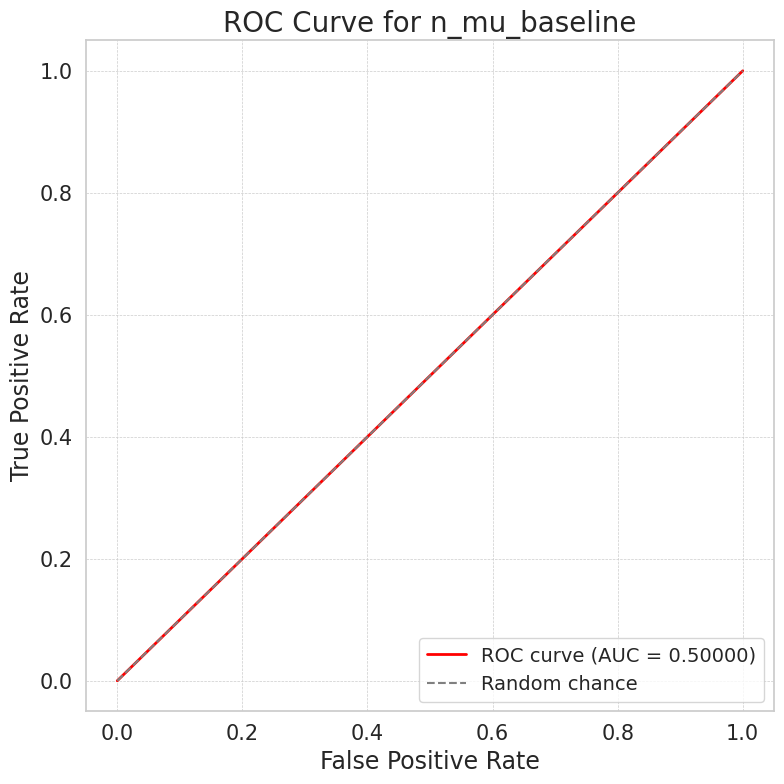

In [33]:
tot2 = tot2_optimized_cuts
# tot2 = tot
cut_name = 'selection'
var_config = getVarDict(tot2[0], 'ggHyyd')

# path for plot storage
mt_val_dir = 'mt100_140'

for var in var_config:
    # print(var)
    bg_values = []     
    bg_weights = []    
    bg_colors = []     
    bg_labels = []     

    signal_values = [] 
    signal_weights = []
    signal_color = None 
    signal_label = None

    for j in range(len(ntuple_names)):
        process = ntuple_names[j]
        fb = tot2[j]  # TTree
        var_config = getVarDict(fb, process, var_name=var)

        x = var_config[var]['var'] # TBranch
        bins = var_config[var]['bins'] 
        weights = fb['weights']
        
        sample_info = sample_dict[process]
        color = sample_info['color']
        legend = sample_info['legend']

        
        if process == 'ggHyyd':  # signal
            signal_values.append(x)
            signal_weights.append(weights)
            signal_color = color
            signal_label = legend
        else:   # background
            bg_values.append(x)
            bg_weights.append(weights)
            bg_colors.append(color)
            bg_labels.append(legend)

    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})

    ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                label=bg_labels, stacked=True)

    ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                label=signal_label, histtype='step', linewidth=2)

    signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
    signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])

    # Add error bar for signal (top plot)
    if len(signal_all) > 0:
        signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)

        ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                        color=signal_color, capsize=0)

    ax_top.set_yscale('log')
    ax_top.set_ylim(0.0001, 1e11)
    ax_top.set_xlim(bins[0], bins[-1])
    ax_top.minorticks_on()
    ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax_top.set_ylabel("Events")
    ax_top.legend(ncol=2)

    bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
    bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])

    # Compute the weighted histogram counts using np.histogram
    S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
    B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     

    # Compute per-bin significance
    sig_simple = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_b = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_1p3b = np.zeros_like(S_counts, dtype=float)

    sqrt_B = np.sqrt(B_counts)
    sqrt_SplusB = np.sqrt(S_counts + B_counts)
    sqrt_Splus1p3B = np.sqrt(S_counts + 1.3 * B_counts)

    # Avoid division by zero safely
    sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
    sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
    sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)

    # Add Binomial ExpZ per bin
    zbi_per_bin = np.array([
        zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3)
        for i in range(len(S_counts))
    ])

    # Compute the bin centers for plotting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute the total significance: total S / sqrt(total B)
    total_signal = np.sum(S_counts)
    total_bkg = np.sum(B_counts)

    if total_bkg > 0:
        total_sig_simple = total_signal / np.sqrt(total_bkg)
        total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg)
        total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg)
        total_sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
    else:
        total_sig_simple = total_sig_s_plus_b = total_sig_s_plus_1p3b = total_sig_binomial = 0

    # --- Plot all significance curves ---
    ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                label=f"S/√B = {total_sig_simple:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
    ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                label=f"Binomial ExpZ = {total_sig_binomial:.4f}")

    ax_bot.set_xlabel(var_config[var]['title'])
    # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
    ax_bot.set_ylabel("Significance")
    # ax_bot.set_ylim(-0.8, 2)
    ax_top.set_xlim(bins[0], bins[-1])

    # Do not set a title on the bottom plot.
    ax_bot.set_title("")

    # Draw a legend with purple text.
    leg = ax_bot.legend()
    for text in leg.get_texts():
        text.set_color('purple')

    plt.xlim(bins[0], bins[-1])
    plt.tight_layout()
    plt.savefig(f"/home/jlai/dark_photon/main/{mt_val_dir}/{cut_name}cut/{var}.png")
    print(f"successfully saved to /home/jlai/dark_photon/main/{mt_val_dir}/{cut_name}cut/{var}.png")
    plt.close()
    # plt.show()

    y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
    y_scores = np.concatenate([signal_all, bg_all])
    # Combine the weights for all events.
    y_weights = np.concatenate([signal_weights_all, bg_weights_all])

    # Compute the weighted ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    roc_auc = auc(fpr_sorted, tpr_sorted)

    # Create a new figure for the ROC curve.
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {var}")
    plt.legend(loc="lower right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()    
    plt.savefig(f"/home/jlai/dark_photon/main/{mt_val_dir}/{cut_name}cut/roc_curve_{var}.png")
    plt.close()
    # plt.show()


In [34]:
mt_val_dir = 'mt100_140'
n_1_config = ["VertexBDTScore", "metsig", "ph_eta", "dmet", "dphi_jj",  "dphi_met_jetterm"]

def sel(tot, n_1_name=None):
    tot2 = []
    for i in range(len(tot)):
        fb2 = tot[i]
    
        if n_1_name != "VertexBDTScore":
            fb2 = fb2[fb2['VertexBDTScore'] >= 0.12]

        # if n_1_name != "dphi_met_phterm":
        #     fb2 = fb2[fb2['dphi_met_phterm'] >= 1.35]

        # if n_1_name != "balance":
            # fb2 = fb2[fb2['balance'] >= 1.35]

        if n_1_name != "metsig":
            metsig_tmp = fb2['met_tst_sig'] 
            mask1 = metsig_tmp >= 7
            # fb2 = fb2[mask1]
            mask2 = metsig_tmp <= 16
            fb2 = fb2[mask1]
        
        if n_1_name != "ph_eta":
            ph_eta_tmp = np.abs(ak.firsts(fb2['ph_eta']))
            fb2 = fb2[ph_eta_tmp <= 1.75]

        if n_1_name != "dmet":
            dmet_tmp = fb2['dmet']
            mask1 = dmet_tmp >= -15000
            mask2 = dmet_tmp <= 50000
            fb2 = fb2[mask1]

        if n_1_name != "dphi_met_jetterm":
            dphi_met_jetterm_tmp = fb2['dphi_met_jetterm']
            fb2 = fb2[dphi_met_jetterm_tmp <= 0.8]

        if n_1_name != "dphi_jj":
            dphi_jj_tmp = fb['dphi_central_jj']
            dphi_jj_tmp = ak.where(dphi_jj_tmp == -10, np.nan, dphi_jj_tmp)
            dphi_jj_tmp = np.arccos(np.cos(dphi_jj_tmp))
            dphi_jj_tmp = ak.where(np.isnan(dphi_jj_tmp), -999, dphi_jj_tmp)
            fb2 = fb2[dphi_jj_tmp <= 2.3]

        
        tot2.append(fb2)
    return tot2

# tot2 = sel(tot)
tot2 = tot

signal_name = 'ggHyyd'  # Define signal dataset
cut_name = 'n-1'

def getCutDict(n_1_name=None):  # same cuts as your original dict
    cut_dict = {}

    if n_1_name is None or n_1_name == "VertexBDTScore":
        cut_dict['VertexBDTScore'] = {
            'lowercut': np.arange(0.1, 0.24, 0.02),  # VertexBDTScore > cut
        }

    if n_1_name is None or n_1_name == "dmet":
        cut_dict['dmet'] = {
            'lowercut': np.arange(-30000, 10000 + 5000, 5000),  # dmet > cut
        }

    if n_1_name is None or n_1_name == "metsig":
        cut_dict['metsig'] = {
            'lowercut': np.arange(0, 10 + 1, 1),  # metsig > cut
        }

    if n_1_name is None or n_1_name == "dphi_met_phterm":
        cut_dict['dphi_met_phterm'] = {
            'lowercut': np.arange(1, 2 + 0.05, 0.05),  # dphi_met_phterm > cut
        }

    if n_1_name is None or n_1_name == "dphi_met_jetterm":
        cut_dict['dphi_met_jetterm'] = {
            'uppercut': np.arange(0.5, 1, 0.05),  # dphi_met_jetterm < cut
        }

    if n_1_name is None or n_1_name == "ph_eta":
        cut_dict['ph_eta'] = {
            'uppercut': np.arange(1, 2.5 + 0.05, 0.05),  # ph_eta < cut
        }

    if n_1_name is None or n_1_name == "dphi_jj":
        cut_dict['dphi_jj'] = {
            'uppercut': np.arange(1, 3.1 + 0.05, 0.05),  # dphi_jj < cut
        }

    return cut_dict

cut_config = getCutDict()

for cut_var_tmp in n_1_config:
    cut_config = getCutDict(n_1_name=cut_var_tmp)
    tot2 = sel(tot, n_1_name=cut_var_tmp)
    for cut_var, cut_types in cut_config.items():
        for cut_type, cut_values in cut_types.items():
            (sig_simple_list, sig_s_plus_b_list, sig_s_plus_1p3b_list, sig_binomial_list,
            sigacc_simple_list, sigacc_s_plus_b_list, sigacc_s_plus_1p3b_list, sigacc_binomial_list,
            acceptance_values) = calculate_significance(cut_var, cut_type, cut_values)

            # Plot results
            fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

            max_tmp = cut_values[np.argmax(sig_simple_list)]
            ax_top.axvline(x=max_tmp, color='r', linestyle='--', label=f'Max S/√B at {max_tmp:.2f}')
            ax_bot.axvline(x=max_tmp, color='r', linestyle='--')

            # Top plot: Significance vs. Cut
            ax_top.plot(cut_values, sig_simple_list, marker='o', label='S/√B')
            # ax_top.plot(cut_values, sig_s_plus_b_list, marker='s', label='S/√(S+B)')
            # ax_top.plot(cut_values, sig_s_plus_1p3b_list, marker='^', label='S/√(S+1.3B)')
            # ax_top.plot(cut_values, sig_binomial_list, marker='x', label='BinomialExpZ')
            ax_top.set_ylabel('Significance')
            ax_top.set_title(f'Significance vs. {cut_var} ({cut_type})')
            ax_top.legend()
            ax_top.grid(True)

            # Bottom plot: Significance * Acceptance vs. Cut
            ax_bot.plot(cut_values, sigacc_simple_list, marker='o', label='(S/√B) × Acceptance')
            # ax_bot.plot(cut_values, sigacc_s_plus_b_list, marker='s', label='(S/√(S+B)) × Acceptance')
            # ax_bot.plot(cut_values, sigacc_s_plus_1p3b_list, marker='^', label='(S/√(S+1.3B)) × Acceptance')
            # ax_bot.plot(cut_values, sigacc_binomial_list, marker='x', label='BinomialExpZ × Acceptance')

            for i, txt in enumerate(acceptance_values):
                ax_bot.text(cut_values[i], sigacc_simple_list[i], f'{txt:.1f}%', 
                            fontsize=10, ha='right', va='bottom', color='purple')
                
            ax_bot.set_xlabel(f'{cut_var} Cut')
            ax_bot.set_ylabel('Significance × Acceptance')
            ax_bot.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
            
            ax_bot.set_xticks(cut_values)
            ax_bot.set_xticklabels(ax_bot.get_xticks(), rotation=45, ha='right')
            ax_bot.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            # ax_bot.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Show at most 10 x-ticks
            
            var_configs_tmp = getVarDict(tot2[0], signal_name, cut_var)
            ax_bot.set_xlabel(var_configs_tmp[cut_var]['title'])
            ax_bot.legend()
            ax_bot.grid(True)

            plt.tight_layout()
            plt.savefig(f"/home/jlai/dark_photon/main/{mt_val_dir}/{cut_name}cut/significance_{cut_var}_{cut_type}.png")
            print(f"Successfully saved to /home/jlai/dark_photon/main/{mt_val_dir}/{cut_name}cut/significance_{cut_var}_{cut_type}.png")
            plt.close()


    var_config = getVarDict(tot2[0], 'ggHyyd', var_name=cut_var_tmp)

    for var in var_config:
        # print(var)
        bg_values = []     
        bg_weights = []    
        bg_colors = []     
        bg_labels = []     

        signal_values = [] 
        signal_weights = []
        signal_color = None 
        signal_label = None

        for j in range(len(ntuple_names)):
            process = ntuple_names[j]
            fb = tot2[j]  # TTree
            var_config = getVarDict(fb, process, var_name=var)

            x = var_config[var]['var'] # TBranch
            bins = var_config[var]['bins'] 
            weights = fb['weights']
            
            sample_info = sample_dict[process]
            color = sample_info['color']
            legend = sample_info['legend']

            
            if process == 'ggHyyd':  # signal
                signal_values.append(x)
                signal_weights.append(weights)
                signal_color = color
                signal_label = legend
            else:   # background
                bg_values.append(x)
                bg_weights.append(weights)
                bg_colors.append(color)
                bg_labels.append(legend)

        fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})

        ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                    label=bg_labels, stacked=True)

        ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                    label=signal_label, histtype='step', linewidth=2)

        signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
        signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])

        # Add error bar for signal (top plot)
        if len(signal_all) > 0:
            signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
            sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)

            ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                            color=signal_color, capsize=0)

        ax_top.set_yscale('log')
        ax_top.set_ylim(0.0001, 1e11)
        ax_top.set_xlim(bins[0], bins[-1])
        ax_top.minorticks_on()
        ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax_top.set_ylabel("Events")
        ax_top.legend(ncol=2)
        # ax_top.set_title("vtx_sumPt distribution")

        bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
        bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])

        # Compute the weighted histogram counts using np.histogram
        S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     

        # Compute per-bin significance
        sig_simple = np.zeros_like(S_counts, dtype=float)
        sig_s_plus_b = np.zeros_like(S_counts, dtype=float)
        sig_s_plus_1p3b = np.zeros_like(S_counts, dtype=float)

        sqrt_B = np.sqrt(B_counts)
        sqrt_SplusB = np.sqrt(S_counts + B_counts)
        sqrt_Splus1p3B = np.sqrt(S_counts + 1.3 * B_counts)

        # Avoid division by zero safely
        sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
        sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
        sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)

        # Add Binomial ExpZ per bin
        zbi_per_bin = np.array([
            zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3)
            for i in range(len(S_counts))
        ])

        # Compute the bin centers for plotting
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # Compute the total significance: total S / sqrt(total B)
        total_signal = np.sum(S_counts)
        total_bkg = np.sum(B_counts)

        if total_bkg > 0:
            total_sig_simple = total_signal / np.sqrt(total_bkg)
            total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg)
            total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg)
            total_sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
        else:
            total_sig_simple = total_sig_s_plus_b = total_sig_s_plus_1p3b = total_sig_binomial = 0

        # --- Plot all significance curves ---
        ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                    label=f"S/√B = {total_sig_simple:.4f}")
        ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                    label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
        ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                    label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
        ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                    label=f"Binomial ExpZ = {total_sig_binomial:.4f}")

        ax_bot.set_xlabel(var_config[var]['title'])
        # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
        ax_bot.set_ylabel("Significance")
        ax_bot.set_ylim(-0.8, 2)
        ax_top.set_xlim(bins[0], bins[-1])

        # Do not set a title on the bottom plot.
        ax_bot.set_title("")

        # Draw a legend with purple text.
        leg = ax_bot.legend()
        for text in leg.get_texts():
            text.set_color('purple')

        plt.xlim(bins[0], bins[-1])
        plt.tight_layout()
        plt.savefig(f"/home/jlai/dark_photon/main/{mt_val_dir}/basiccut/{var}.png")
        print(f"successfully saved to /home/jlai/dark_photon/main/{mt_val_dir}/basiccut/{var}.png")
        plt.close()
        # plt.show()

        y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
        # Use the vtx_sumPt values as the classifier output.
        y_scores = np.concatenate([signal_all, bg_all])
        # Combine the weights for all events.
        y_weights = np.concatenate([signal_weights_all, bg_weights_all])

        # Compute the weighted ROC curve.
        fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
        sorted_indices = np.argsort(fpr)
        fpr_sorted = fpr[sorted_indices]
        tpr_sorted = tpr[sorted_indices]

        roc_auc = auc(fpr_sorted, tpr_sorted)

        # Create a new figure for the ROC curve.
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {var}")
        plt.legend(loc="lower right")
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.tight_layout()    
        plt.savefig(f"/home/jlai/dark_photon/main/{mt_val_dir}/basiccut/roc_curve_{var}.png")
        plt.close()
        # plt.show()

IndexError: cannot slice RegularArray (of length 1) with [    0     1     2 ... 49569 49570 49571]: index out of range while attempting to get index 1935 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-40/awkward-cpp/src/cpu-kernels/awkward_RegularArray_getitem_next_array_regularize.cpp#L19)

This error occurred while attempting to slice

    <Array [{run: 602402, event: ..., ...}, ...] type='1935 * ?{run: int32,...'>

with

    <Array [True, True, True, True, ..., True, True, True] type='49572 * ?bool'>

In [35]:
# --- config ---
mt_val_dir = 'mt100_140'
n_1_config = ["VertexBDTScore", "metsig", "ph_eta", "dmet", "dphi_jj", "dphi_met_jetterm"]
signal_name = 'ggHyyd'
cut_name = 'n-1'  # used to route outputs into the /{cut_name}cut/ dir

# --- helpers ---

from pathlib import Path

def ensure_dir(path_str):
    Path(path_str).mkdir(parents=True, exist_ok=True)

def to_np(a):
    """Flatten awkward/numpy to 1D numpy array; empty-safe."""
    if a is None:
        return np.array([])
    try:
        import awkward as ak
        if hasattr(ak, "to_numpy"):
            return ak.to_numpy(ak.flatten(a, axis=None))
    except Exception:
        pass
    return np.asarray(a).ravel()

def safe_concat(list_of_arrays):
    """Concatenate list of arrays safely (possibly empty)."""
    if len(list_of_arrays) == 0:
        return np.array([])
    arrs = [to_np(x) for x in list_of_arrays if x is not None]
    return np.concatenate(arrs) if len(arrs) else np.array([])

def safe_hist(x, bins, w=None):
    if x.size == 0:
        return np.zeros(len(bins)-1, dtype=float), bins
    return np.histogram(x, bins=bins, weights=w)

def sel(tot, n_1_name=None):
    """
    Apply baseline cuts to all fb in tot except the variable named by n_1_name.
    """
    import awkward as ak
    out = []
    for i in range(len(tot)):
        fb2 = tot[i]

        # VertexBDTScore > 0.12 (unless N-1 on it)
        if n_1_name != "VertexBDTScore":
            fb2 = fb2[fb2['VertexBDTScore'] >= 0.12]

        # metsig: 7 <= met_tst_sig <= 16 (only lower applied previously; fix & allow N-1)
        if n_1_name != "metsig":
            metsig_tmp = fb2['met_tst_sig']
            fb2 = fb2[(metsig_tmp >= 7) & (metsig_tmp <= 16)]

        # photon |eta| < 1.75
        if n_1_name != "ph_eta":
            ph_eta_tmp = np.abs(ak.firsts(fb2['ph_eta']))
            fb2 = fb2[ph_eta_tmp <= 1.75]

        # dmet in [-15000, 50000]
        if n_1_name != "dmet":
            dmet_tmp = fb2['dmet']
            fb2 = fb2[(dmet_tmp >= -15000) & (dmet_tmp <= 50000)]

        # dphi_met_jetterm < 0.8
        if n_1_name != "dphi_met_jetterm":
            dphi_met_jetterm_tmp = fb2['dphi_met_jetterm']
            fb2 = fb2[dphi_met_jetterm_tmp <= 0.8]

        # dphi_jj < 2.3   (fix fb->fb2, keep wrap into [0,pi], treat sentinel -10)
        if n_1_name != "dphi_jj":
            dphi_jj_tmp = fb2['dphi_central_jj']
            dphi_jj_tmp = ak.where(dphi_jj_tmp == -10, np.nan, dphi_jj_tmp)
            dphi_jj_tmp = np.arccos(np.cos(dphi_jj_tmp))
            dphi_jj_tmp = ak.where(np.isnan(dphi_jj_tmp), -999, dphi_jj_tmp)
            fb2 = fb2[dphi_jj_tmp <= 2.3]

        out.append(fb2)
    return out

def getCutDict(n_1_name=None):
    cut_dict = {}
    if n_1_name is None or n_1_name == "VertexBDTScore":
        cut_dict['VertexBDTScore'] = {'lowercut': np.arange(0.10, 0.24, 0.02)}
    if n_1_name is None or n_1_name == "dmet":
        cut_dict['dmet'] = {'lowercut': np.arange(-30000, 10000 + 5000, 5000)}
    if n_1_name is None or n_1_name == "metsig":
        cut_dict['metsig'] = {'lowercut': np.arange(0, 10 + 1, 1)}
    if n_1_name is None or n_1_name == "dphi_met_phterm":
        cut_dict['dphi_met_phterm'] = {'lowercut': np.arange(1, 2 + 0.05, 0.05)}
    if n_1_name is None or n_1_name == "dphi_met_jetterm":
        cut_dict['dphi_met_jetterm'] = {'uppercut': np.arange(0.5, 1.00, 0.05)}
    if n_1_name is None or n_1_name == "ph_eta":
        cut_dict['ph_eta'] = {'uppercut': np.arange(1.0, 2.50 + 0.05, 0.05)}
    if n_1_name is None or n_1_name == "dphi_jj":
        cut_dict['dphi_jj'] = {'uppercut': np.arange(1.0, 3.10 + 0.05, 0.05)}
    return cut_dict

# You already have calculate_significance(cut_var, cut_type, cut_values)
# assuming it uses global ntuple_names, sample_dict, tot2, signal_name, etc.

# ---------- N-1 scan + plots ----------

out_base = f"/home/jlai/dark_photon/main/{mt_val_dir}/{cut_name}cut"
ensure_dir(out_base)

def calculate_significance(cut_var, cut_type, cut_values):
    sig_simple_list = []
    sig_s_plus_b_list = []
    sig_s_plus_1p3b_list = []
    sig_binomial_list = []

    sigacc_simple_list = []
    sigacc_s_plus_b_list = []
    sigacc_s_plus_1p3b_list = []
    sigacc_binomial_list = []

    acceptance_values = []  # Store acceptance percentages

    for cut in cut_values:
        sig_after_cut = 0
        bkg_after_cut = []
        sig_events = 0
        
        for i in range(len(ntuple_names)):
            fb = tot2[i]
            process = ntuple_names[i]
            var_config = getVarDict(fb, process, var_name=cut_var)
            x = var_config[cut_var]['var']
            mask = x != -999 # Apply cut: Remove -999 values 
            x = x[mask]

            if process == signal_name:
                sig_events = fb['weights']
                sig_events = sig_events[mask]
                if cut_type == 'lowercut':
                    mask = x >= cut
                elif cut_type == 'uppercut':
                    mask = x <= cut
                else:
                    raise ValueError("Invalid cut type")
                sig_after_cut = ak.sum(sig_events[mask])
            
            else:
                bkg_events = fb['weights']
                bkg_events = bkg_events[mask]
                if cut_type == 'lowercut':
                    mask = x >= cut
                elif cut_type == 'uppercut':
                    mask = x <= cut
                else:
                    raise ValueError("Invalid cut type")
                bkg_after_cut.append(ak.sum(bkg_events[mask]))

       # Now compute different types of significance
        total_bkg = sum(bkg_after_cut)
        total_signal = sig_after_cut

        # Avoid zero division carefully
        if total_bkg > 0:
            sig_simple = total_signal / np.sqrt(total_bkg)
            sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg) if (total_signal + total_bkg) > 0 else 0
            sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg) if (total_signal + 1.3*total_bkg) > 0 else 0
            sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
        else:
            sig_simple = sig_s_plus_b = sig_s_plus_1p3b = sig_binomial = 0

        # Acceptance
        acceptance = total_signal / sum(sig_events) if sum(sig_events) > 0 else 0
        acceptance_values.append(acceptance * 100)  # percentage

        # Save significance
        sig_simple_list.append(sig_simple)
        sig_s_plus_b_list.append(sig_s_plus_b)
        sig_s_plus_1p3b_list.append(sig_s_plus_1p3b)
        sig_binomial_list.append(sig_binomial)

        # Save significance × acceptance
        sigacc_simple_list.append(sig_simple * acceptance)
        sigacc_s_plus_b_list.append(sig_s_plus_b * acceptance)
        sigacc_s_plus_1p3b_list.append(sig_s_plus_1p3b * acceptance)
        sigacc_binomial_list.append(sig_binomial * acceptance)

    return (sig_simple_list, sig_s_plus_b_list, sig_s_plus_1p3b_list, sig_binomial_list,
            sigacc_simple_list, sigacc_s_plus_b_list, sigacc_s_plus_1p3b_list, sigacc_binomial_list,
            acceptance_values)


for cut_var_tmp in n_1_config:
    # Build cut grid for THIS n-1 variable and apply baseline to all others
    cut_config = getCutDict(n_1_name=cut_var_tmp)
    tot2 = sel(tot, n_1_name=cut_var_tmp)

    # --- Significance vs cut scans for this n-1 variable ---
    for cut_var, cut_types in cut_config.items():
        for cut_type, cut_values in cut_types.items():
            (sig_simple_list, sig_s_plus_b_list, sig_s_plus_1p3b_list, sig_binomial_list,
             sigacc_simple_list, sigacc_s_plus_b_list, sigacc_s_plus_1p3b_list, sigacc_binomial_list,
             acceptance_values) = calculate_significance(cut_var, cut_type, cut_values)

            fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

            # Top: S/sqrt(B) and vertical line at max
            i_max = int(np.argmax(sig_simple_list)) if len(sig_simple_list) else 0
            max_tmp = float(cut_values[i_max]) if len(cut_values) else np.nan
            if len(cut_values):
                ax_top.axvline(x=max_tmp, color='r', linestyle='--', label=f'Max S/√B at {max_tmp:.2f}')
            ax_top.plot(cut_values, sig_simple_list, marker='o', label='S/√B')
            # Uncomment if you want the other metrics on same plot:
            # ax_top.plot(cut_values, sig_s_plus_b_list, marker='s', label='S/√(S+B)')
            # ax_top.plot(cut_values, sig_s_plus_1p3b_list, marker='^', label='S/√(S+1.3B)')
            # ax_top.plot(cut_values, sig_binomial_list, marker='x', label='BinomialExpZ')
            ax_top.set_ylabel('Significance')
            ax_top.set_title(f'N-1: {cut_var_tmp} — Significance vs. {cut_var} ({cut_type})')
            ax_top.grid(True)
            ax_top.legend()

            # Bottom: (S/√B) × Acceptance
            if len(cut_values):
                ax_bot.axvline(x=max_tmp, color='r', linestyle='--')
            ax_bot.plot(cut_values, sigacc_simple_list, marker='o', label='(S/√B) × Acceptance')

            for i, acc in enumerate(acceptance_values):
                ax_bot.text(cut_values[i], sigacc_simple_list[i], f'{acc:.1f}%',
                            fontsize=9, ha='right', va='bottom', color='purple')

            # Label with pretty var title
            var_cfg_for_label = getVarDict(tot2[0], signal_name, cut_var)
            ax_bot.set_xlabel(var_cfg_for_label[cut_var]['title'])
            ax_bot.set_ylabel('Significance × Acceptance')
            ax_bot.grid(True)
            ax_bot.legend()

            plt.tight_layout()
            out_path = f"{out_base}/significance_{cut_var}_{cut_type}.png"
            ensure_dir(Path(out_path).parent.as_posix())
            plt.savefig(out_path)
            print(f"Saved: {out_path}")
            plt.close()

    # --- N-1 distributions + per-bin significance & ROC for THIS variable ---
    var_cfg_sig = getVarDict(tot2[0], signal_name, var_name=cut_var_tmp)  # only request this var
    for var in var_cfg_sig:
        bg_vals, bg_wts, bg_cols, bg_labs = [], [], [], []
        sig_vals, sig_wts = [], []
        sig_col = None
        sig_lab = None

        # Build stacks
        for j in range(len(ntuple_names)):
            process = ntuple_names[j]
            fb2 = tot2[j]
            var_cfg = getVarDict(fb2, process, var_name=var)
            x = var_cfg[var]['var']
            bins = var_cfg[var]['bins']
            weights = fb2['weights']

            info = sample_dict[process]
            if process == signal_name:
                sig_vals.append(x)
                sig_wts.append(weights)
                sig_col = info['color']; sig_lab = info['legend']
            else:
                bg_vals.append(x); bg_wts.append(weights)
                bg_cols.append(info['color']); bg_labs.append(info['legend'])

        # Convert/concat
        sig_all = safe_concat(sig_vals)
        sig_w_all = safe_concat(sig_wts)
        bg_all = safe_concat(bg_vals)
        bg_w_all = safe_concat(bg_wts)

        # Figure / axes
        fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios':[9,4]})

        # Stacked BG + signal outline
        if len(bg_vals):
            ax_top.hist([to_np(v) for v in bg_vals], bins=bins,
                        weights=[to_np(w) for w in bg_wts], color=bg_cols,
                        label=bg_labs, stacked=True)
        if sig_all.size:
            ax_top.hist(sig_all, bins=bins, weights=sig_w_all, color=sig_col,
                        label=sig_lab, histtype='step', linewidth=2)

            # Signal error bars
            s_counts, s_edges = safe_hist(sig_all, bins=bins, w=sig_w_all)
            s2, _ = safe_hist(sig_all, bins=bins, w=sig_w_all**2 if sig_w_all.size else None)
            bin_centers = 0.5*(s_edges[:-1] + s_edges[1:])
            s_err = np.sqrt(s2)
            ax_top.errorbar(bin_centers, s_counts, yerr=s_err, fmt='.', linewidth=2,
                            color=sig_col, capsize=0)

        ax_top.set_yscale('log')
        ax_top.set_ylim(max(1e-4, 1e-6), 1e11)
        ax_top.set_xlim(bins[0], bins[-1])
        ax_top.minorticks_on()
        ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax_top.set_ylabel("Events")
        ax_top.legend(ncol=2)

        # Per-bin significance curves
        S_counts, _ = safe_hist(sig_all, bins=bins, w=sig_w_all)
        B_counts, _ = safe_hist(bg_all, bins=bins, w=bg_w_all)

        sqrt_B = np.sqrt(np.clip(B_counts, 0, None))
        sqrt_SplusB = np.sqrt(np.clip(S_counts + B_counts, 0, None))
        sqrt_Splus1p3B = np.sqrt(np.clip(S_counts + 1.3*B_counts, 0, None))

        sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0.0)
        sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0.0)
        sig_s_plus_1p3b = np.where((S_counts + 1.3*B_counts) > 0, S_counts / sqrt_Splus1p3B, 0.0)

        # Binomial ExpZ per bin
        zbi_per_bin = np.array([zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3) for i in range(len(S_counts))])

        bin_centers = 0.5*(bins[:-1] + bins[1:])

        # Totals
        S_tot = float(np.sum(S_counts))
        B_tot = float(np.sum(B_counts))
        if B_tot > 0:
            tot_SsqrtB = S_tot / np.sqrt(B_tot)
            tot_SsqrtSB = S_tot / np.sqrt(S_tot + B_tot) if (S_tot + B_tot) > 0 else 0
            tot_SsqrtS1p3B = S_tot / np.sqrt(S_tot + 1.3*B_tot) if (S_tot + 1.3*B_tot) > 0 else 0
            tot_zbi = zbi(S_tot, B_tot, sigma_b_frac=0.3)
        else:
            tot_SsqrtB = tot_SsqrtSB = tot_SsqrtS1p3B = tot_zbi = 0.0

        ax_bot.step(bin_centers, sig_simple, where='mid', linewidth=2,
                    label=f"S/√B = {tot_SsqrtB:.4f}", color='chocolate')
        ax_bot.step(bin_centers, sig_s_plus_b, where='mid', linewidth=2,
                    label=f"S/√(S+B) = {tot_SsqrtSB:.4f}", color='tomato')
        ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', linewidth=2,
                    label=f"S/√(S+1.3B) = {tot_SsqrtS1p3B:.4f}", color='orange')
        ax_bot.step(bin_centers, zbi_per_bin, where='mid', linewidth=2,
                    label=f"Binomial ExpZ = {tot_zbi:.4f}", color='plum')

        ax_bot.set_xlabel(var_cfg_sig[var]['title'])
        ax_bot.set_ylabel("Significance")
        ax_bot.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax_bot.set_title("")
        leg = ax_bot.legend()
        for t in leg.get_texts():
            t.set_color('purple')

        plt.xlim(bins[0], bins[-1])
        plt.tight_layout()

        dist_dir = f"{out_base}"
        ensure_dir(dist_dir)
        out_png = f"{dist_dir}/{var}.png"
        plt.savefig(out_png)
        print(f"Saved: {out_png}")
        plt.close()

        # ROC using this single variable as score
        y_true = np.concatenate([np.ones_like(S_counts).repeat(1)])  # placeholder to silence lints
        # Build event-wise arrays, not binned:
        y_true = np.concatenate([np.ones(sig_all.shape[0], dtype=int), np.zeros(bg_all.shape[0], dtype=int)])
        y_scores = np.concatenate([sig_all, bg_all])
        y_w = np.concatenate([sig_w_all if sig_w_all.size else np.ones(sig_all.shape[0]),
                              bg_w_all if bg_w_all.size else np.ones(bg_all.shape[0])])

        if y_scores.size and np.unique(y_true).size == 2:
            fpr, tpr, thr = roc_curve(y_true, y_scores, sample_weight=y_w)
            order = np.argsort(fpr)
            roc_auc = auc(fpr[order], tpr[order])

            plt.figure(figsize=(8, 8))
            plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.5f})')
            plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"N-1 ROC — {var}")
            plt.legend(loc="lower right")
            plt.grid(True, which="both", linestyle="--", linewidth=0.5)
            plt.tight_layout()
            out_png = f"{dist_dir}/roc_curve_{var}.png"
            plt.savefig(out_png)
            print(f"Saved: {out_png}")
            plt.close()


Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/significance_VertexBDTScore_lowercut.png


/tmp/ipykernel_326/1636279499.py:310: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0.0)
/tmp/ipykernel_326/1636279499.py:311: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0.0)
/tmp/ipykernel_326/1636279499.py:312: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3*B_counts) > 0, S_counts / sqrt_Splus1p3B, 0.0)


Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/VertexBDTScore.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/roc_curve_VertexBDTScore.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/significance_metsig_lowercut.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/metsig.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/roc_curve_metsig.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/significance_ph_eta_uppercut.png


/tmp/ipykernel_326/1636279499.py:310: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0.0)
/tmp/ipykernel_326/1636279499.py:311: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0.0)
/tmp/ipykernel_326/1636279499.py:312: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3*B_counts) > 0, S_counts / sqrt_Splus1p3B, 0.0)


Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/ph_eta.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/roc_curve_ph_eta.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/significance_dmet_lowercut.png


/tmp/ipykernel_326/1636279499.py:310: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0.0)
/tmp/ipykernel_326/1636279499.py:311: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0.0)
/tmp/ipykernel_326/1636279499.py:312: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3*B_counts) > 0, S_counts / sqrt_Splus1p3B, 0.0)


Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/dmet.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/roc_curve_dmet.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/significance_dphi_jj_uppercut.png


/tmp/ipykernel_326/1636279499.py:310: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0.0)
/tmp/ipykernel_326/1636279499.py:311: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0.0)
/tmp/ipykernel_326/1636279499.py:312: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3*B_counts) > 0, S_counts / sqrt_Splus1p3B, 0.0)


Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/dphi_jj.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/roc_curve_dphi_jj.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/significance_dphi_met_jetterm_uppercut.png


/tmp/ipykernel_326/1636279499.py:310: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0.0)
/tmp/ipykernel_326/1636279499.py:311: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0.0)
/tmp/ipykernel_326/1636279499.py:312: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3*B_counts) > 0, S_counts / sqrt_Splus1p3B, 0.0)


Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/dphi_met_jetterm.png
Saved: /home/jlai/dark_photon/main/mt100_140/n-1cut/roc_curve_dphi_met_jetterm.png
